# Preambule

In [12]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns

In [13]:
from sklearn.preprocessing import robust_scale
from sqlalchemy import create_engine
from astropy.io import fits

In [14]:
from ipywidgets import IntProgress
from IPython.display import display

In [15]:
import warnings as war
war.filterwarnings("ignore")

In [16]:
from castor import spec2sqr

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("seaborn-darkgrid")
plt.rcParams["figure.figsize"] = (16, 9)
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["image.cmap"] = "Spectral"

## Load table into dataframe

In [ ]:
%%time
data = pd.read_csv("dr1_stellar_final.csv.gz",
                   sep="|", na_values=[-9999.00, "NULL"],
                   low_memory=False)

In [ ]:
basename = data["mjd"].map("spec-{}-".format)    \
         + data["planid"].map("{}".format)       \
         + data["spid"].map("_sp{:02d}-".format) \
         + data["fiberid"].map("{:03d}".format)
#         + ".fits"
data["basename"] = basename

In [ ]:
data.head()

```python
# eng = create_engine("sqlite:///lamost.db")
# data.to_sql("catalog", eng, if_exists="replace")
```

## Simple Query Language

In [9]:
eng = create_engine("sqlite:///lamost.db5")
tip = ["teff", "logg", "feh"] #! key @Pollux
top = ["teff_err", "logg_err", "feh_err"]
sql = "SELECT {} FROM star"\
      .format(",".join(tip+top))
dat = pd.read_sql(sql, eng)
dat["teff"] = np.log10(dat["teff"])
dat["teff_err"] = np.log10(dat["teff_err"])

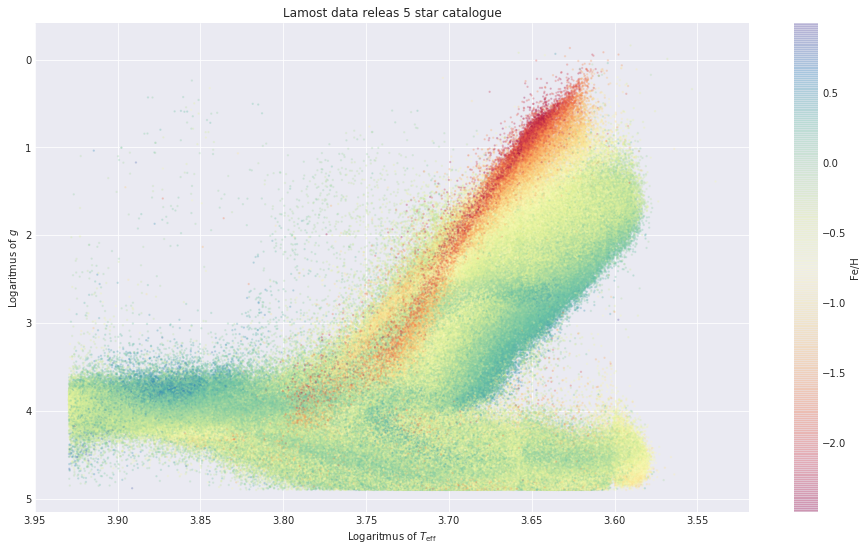

CPU times: user 4min 24s, sys: 1.52 s, total: 4min 26s
Wall time: 4min 25s


In [18]:
%%time
plt.title("Lamost data releas 5 star catalogue")
plt.xlabel("Logaritmus of $T_\mathrm{eff}$")
plt.ylabel("Logaritmus of $g$")
plt.gca().invert_xaxis(); plt.gca().invert_yaxis()
plt.scatter(dat["teff"], dat["logg"],
            c=dat["feh"], s=2, alpha=0.2);
plt.colorbar().ax.set_ylabel("Fe/H");
plt.savefig("lamostDR5.png")
plt.show()
# print(plt.xlim(), plt.ylim()) 

In [20]:
dat.feh.min(), dat.feh.max()

(-2.499, 0.998)

In [ ]:
plt.colorbar?

In [ ]:
plt.figure(figsize=(16,4))
for i, name in enumerate(tip):
#    if i == 2:
#        plt.title("Error distribution")
    plt.subplot(131+i)
    plt.xlabel(tip[i])
    sns.distplot(dat[tip[i]])
#    plt.subplot(234+i)
#    plt.scatter(dat[tip[i]], dat[top[i]],
#                s=2, c="gray", alpha=0.5)

In [ ]:
# stvoření lamostu z obsahu vzorku
with open("lamost.lst", "w") as last:
    filenames = glob.glob("/mnt/arch/LAMOST/dr1/sample/*.fits")
    for funy in filenames:
        name = os.path.basename(funy.strip(".fits\n"))
        last.write(name+"\n")

## Spectral normalization

```python
lamost = open("lamost.lst").readlines()
progres = IntProgress(min=0, max=len(lamost))
display(progres)
for name in lamost:
    name = name.strip()
    #if not os.path.exists("lamost/"+name+".npy"):
        #print(name)
    flux = fits.getdata("/mnt/arch/LAMOST/dr1/sample/"+name+".fits")[0]
    sqr = spec2sqr(robust_scale(flux.reshape(-1,1)), a=64) #  castor
    np.save("lamost/"+name+".npy", sqr)
    progres.value += 1
```

## Preview

In [ ]:
lamost = open("lamost.lst").readlines()
lama = np.random.randint(len(lamost))
name = lamost[lama].strip()
path = "/mnt/arch/LAMOST/dr1/sample/"+name+".fits"
flux = fits.getdata(path)[0]
N = fits.getval(path, "NAXIS1")
l = fits.getval(path, "CRVAL1")
s = fits.getval(path, "CD1_1")
wave = np.logspace(l, l+N*s, N)
wave.shape, wave.min(), wave.max()

In [ ]:
plt.figure(figsize=(16,4))
plt.title("Lamost data releas 1 sample spectrum")
plt.xlabel("Wavelength [Ä]")
plt.ylabel("Flux")
plt.scatter(wave, robust_scale(flux), c=1/wave, s=5);

In [ ]:
plt.xticks([]); plt.yticks([])
plt.imshow(spec2sqr(robust_scale(flux)));
plt.colorbar(); ## Relativly important scale!

```python
# zápis předpokládaných výsledků
eng = create_engine("sqlite:///lamost.db")
most = pd.DataFrame({"basename": open("lamost.lst").readlines()})
most.basename = most.basename.map(str.strip)
merg = most.merge(data)
merg.to_sql("sample", eng, if_exists="replace")
merg["teff"] = np.log10(merg["teff"])
np.save("lamost.npy", merg[tip].values)
```

In [ ]:
print("Check")